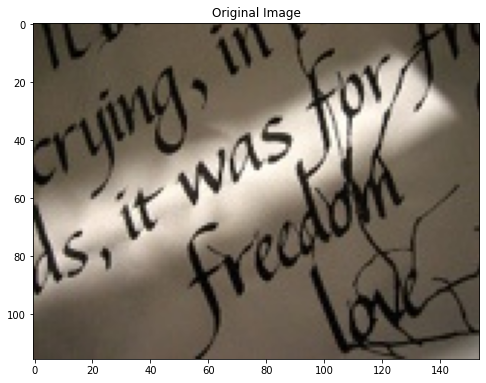

In [15]:
# Implementation of Jian Ren et.al

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color,filters
from scipy import ndimage as ndi
from helper_functions import *


base_img_rpath = '../dataset/document/'
base_img_wpath = '../output/document/'

#choices = 'color_mosaic.jpg', 'textbook.jpg', 'manuscript.jpg'
filename = 'calligraphic.jpg'
doc = Image.open(base_img_rpath + filename)


doc_orig = np.array(doc)

plt.figure(figsize = (8,10))
plt.imshow(doc)
plt.title('Original Image')
plt.show()

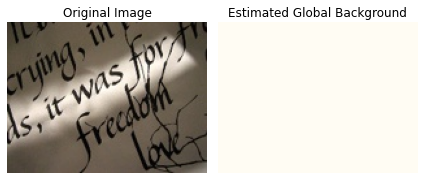

In [16]:
choice = 3
title1 = 'Original Image'
title2 = 'Estimated Global Background'

if choice==1:

  # Global average over each channel  (Approach #1)  
  global_col = doc_orig.copy()
  global_col[:,:,0], global_col[:,:,1], global_col[:,:,2] = np.average(doc_orig, axis=(0,1))
  show_img_compare(doc_orig, global_col, title1, title2)
elif choice==2:

  # Max pixel value for each channel   (Approach #2)
  img_temp = doc_orig.copy()
  # By counting most frequent pixels
  #unique, counts = np.unique(doc_orig.reshape(-1, 3), axis=0, return_counts=True)
  #img_temp[:,:,0], img_temp[:,:,1], img_temp[:,:,2] = unique[np.argmax(counts)]
  img_temp[:,:,0] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * np.max(doc_orig[:,:,0])
  img_temp[:,:,1] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * np.max(doc_orig[:,:,1])
  img_temp[:,:,2] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * np.max(doc_orig[:,:,2])
  show_img_compare(doc_orig, img_temp, title1, title2)
elif choice==3:

  # Average of top 50 pixels   (Approach #3)
  I_global = doc_orig.copy()

  dom_r = np.partition(doc_orig[:,:,0].flatten(), -2)[-50:]
  mean_val_r = np.mean(dom_r)

  dom_g = np.partition(doc_orig[:,:,1].flatten(), -2)[-50:]
  mean_val_g = np.mean(dom_g)

  dom_b = np.partition(doc_orig[:,:,2].flatten(), -2)[-50:]
  mean_val_b = np.mean(dom_b)

  I_global[:,:,0] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * mean_val_r
  I_global[:,:,1] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * mean_val_g
  I_global[:,:,2] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * mean_val_b
  show_img_compare(doc_orig[:,:,:], I_global, title1, title2)


In [21]:
# Preliminary Estimation of Local Background

from skimage.filters.edges import convolve
p = 0.7  #p-percentile
block_size = 9  #block size (only odd) <-- parameter to be tuned
d = block_size//2

m = doc_orig.shape[0]
n = doc_orig.shape[1]

I_local = np.zeros((m,n,3))


for c_ch in range(3):  #loop for each color channel
    for row in range(m):
        for col in range(n):
            #kernel = np.ones((block_size,block_size)) #not ignoring weight of current pixel
            
            block_intensities = doc_orig[max(row-d,0):min(row+d+1,m-1),max(col-d,0):min(col+d+1,n-1),c_ch].flatten()
            I_local[row][col][c_ch] = np.percentile(block_intensities,100*p)

I_local = I_local.astype(int)

In [29]:
# Refined Estimation of Local Background

t = 0.01 #threshold

median_block_size = 13 #odd only
median_d = median_block_size//2

I_local_refined = np.zeros((m,n,3))

for c_ch in range(3):  #loop for each color channel
    for row in range(m):
        for col in range(n):
            if I_local[row][col][c_ch] <= (1+t)*doc_orig[row][col][c_ch] and (1-t)*doc_orig[row][col][c_ch] <= I_local[row][col][c_ch]:
                I_local_refined[row][col][c_ch] = doc_orig[row][col][c_ch]
            else:
                I_local_refined[row][col][c_ch] = np.median(I_local[max(row-median_d,0):min(row+median_d+1,m-1),max(col-median_d,0):min(col+median_d+1,n-1),c_ch].flatten())

I_local_refined = I_local_refined.astype(int)

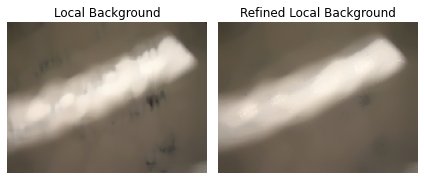

In [30]:
# Plotting local background estimation

title1 = 'Local Background'
title2 = 'Refined Local Background'
f, ax = show_img_compare(I_local, I_local_refined, title1, title2)

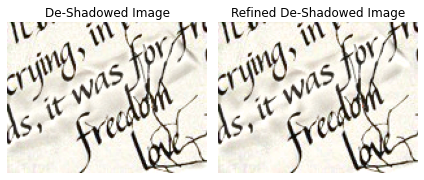

Percentage change: 53.03 % 


In [31]:
#shadow_map = np.zeros(doc_orig.shape)
shadow_map = I_local / I_global    #mostly decimals < 1
shadow_map_refined = I_local_refined / I_global

# Preventing division by zero (see next step)
zero_loc = np.where(shadow_map[:,:,:]==0)
shadow_map[zero_loc] = 1
zero_loc = np.where(shadow_map_refined[:,:,:]==0)
shadow_map_refined[zero_loc] = 1


I_deshadow = doc_orig / shadow_map
I_deshadow_refined = doc_orig / shadow_map_refined

I_deshadow = I_deshadow.astype(int).clip(0,255)
I_deshadow_refined = I_deshadow_refined.astype(int).clip(0,255)

# Plotting
title1 = 'De-Shadowed Image'
title2 = 'Refined De-Shadowed Image'
fig, axes = show_img_compare(I_deshadow, I_deshadow_refined, title1, title2)

#fig.savefig(base_img_wpath + filename[:-4] + '_blk_' + str(d) + '_mblk_' + str(median_d)+ '.jpg')


# Statistics
mismatch_pos = np.where(np.equal(I_deshadow, I_deshadow_refined)==False)[0]
print('Percentage change: {:.2f} % '.format(100*len(mismatch_pos)/(m*n*3)))
